In [1]:
import sys
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs
import nltk
from nltk.corpus import stopwords

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    if sys.version_info > (3.0):
        os.system('python3 -m nltk.downloader stopwords')
    else:
        os.system('pyhton -m nltk.downloader.stopwords')
        
%matplotlib inline
FOLDER_PATH = '/home/vahidsanei_google_com/'

In [2]:
!python -m nltk.downloader stopwords

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vahidsanei_google_com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv(os.path.join(FOLDER_PATH, 'data', 'yelp_data', 'updated', 'business_with_corpus.csv'))
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"<html lang=""en-US""><head>\n\t<meta charset=""UT...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"<html xmlns=""http://www.w3.org/1999/xhtml"" xml...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"<html lang=""en-US"" prefix=""og: http://ogp.me/n...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"<html lang=""en-US"" prefix=""og: http://ogp.me/n...",False,NaN
4,4,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,1,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Ethnic Food, Food Trucks, Specialty Food, Impo...","{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",http://www.theempanadashouse.com,<html><head>\n<title>Website Disabled</title>\...,True,Website Disabled Sorry the site you requested ...


In [4]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       'is_eng', 'webpage_corpus'],
      dtype='object')

In [5]:
df = df[df['categories'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5104 entries, 0 to 5106
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5104 non-null   int64  
 1   business_id     5104 non-null   object 
 2   name            5104 non-null   object 
 3   address         4860 non-null   object 
 4   city            5104 non-null   object 
 5   state           5104 non-null   object 
 6   postal_code     5098 non-null   object 
 7   latitude        5104 non-null   float64
 8   longitude       5104 non-null   float64
 9   stars           5104 non-null   float64
 10  review_count    5104 non-null   int64  
 11  is_open         5104 non-null   int64  
 12  attributes      4398 non-null   object 
 13  categories      5104 non-null   object 
 14  hours           4336 non-null   object 
 15  url             5104 non-null   object 
 16  webpage_text    5104 non-null   object 
 17  is_eng          5104 non-null   b

In [6]:
df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


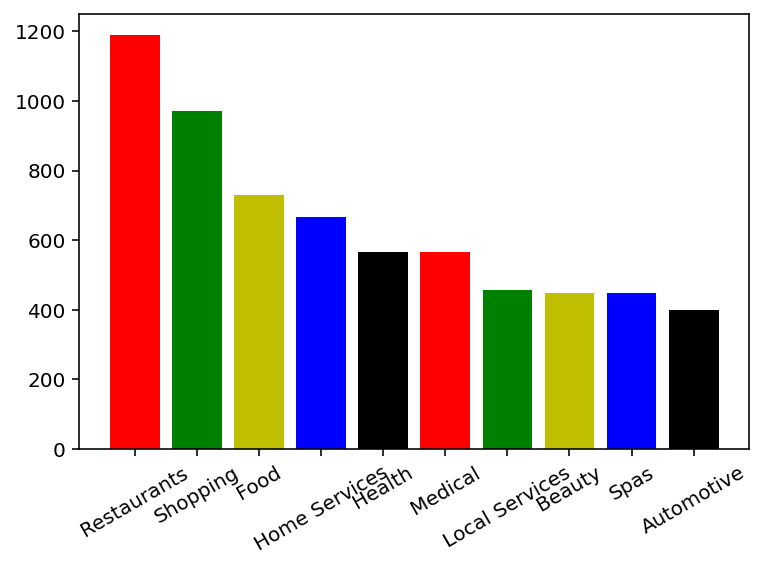

In [7]:
Categories={}

for x in df.categories:
    for cls in x:
        cls = cls.strip()
        if len(cls) < 2: continue
        if cls not in Categories: Categories[cls]=1
        else: Categories[cls]+=1

All_categories=list(Categories.keys())
classes=[[x,Categories[x]] for x in All_categories]
classes=sorted(classes, key=lambda x: x[1], reverse=True)
all_classes = classes
classes=classes[:10]
plt.bar(range(len(classes)),[x[1] for x in classes] ,align='center', color='rgybk')
plt.xticks(range(len(classes)), [x[0] for x in classes], rotation=30);

In [8]:
all_classes=sorted(all_classes, key=lambda x: x[1], reverse=True)

In [ ]:
map_classes = {
                'Restaurants': 'Food', 'Food': 'Food', 'Frozen Yogurt': 'Food', 'Pizza': 'Food', 'Bars': 'Food', 'Coffee': 'Food',
                'Cafes': 'Food', 'Fast Food': 'Food', 'Bakeries': 'Food', 'Tea' : 'Food', 'Breakfast': 'Food',
                'Wine': 'Food', 'Sandwiches': 'Food', 'Burgers': 'Food', 'Brunch': 'Food', 'Breakfast': 'Food', 'Desserts': 'Food',
                'Vegetarian': 'Food', 'Vegan': 'Food', 

                'Health': 'Health', 'Dentists': 'Health', 'Doctors': 'Health', 'Medical Centers': 'Health', 'Drugstores': 'Health',

                'Local Services': 'Local Services', 'Car Dealers': 'Local Services', 'Professional Services': 'Local Services', 
                'Home Services': 'Local Services','Garden': 'Local Services', 'Real Estate': 'Local Services',
                'Auto Repair': 'Local Services', 'Pet Services': 'Local Services', 'Home Cleaning': 'Local Services', 
                'Public Services': 'Local Services', 'Home Decor': 'Local Services', 
                'Automotive': 'Local Services', 'Pets': 'Local Services',
    
                'Hair Salons': 'Fashion', 'Nail Salons': 'Fashion', 'Beauty': 'Fashion', 'Hair Salons': 'Fashion', 'Makeup Artists': 'Fashion',
                'Hair Removal': 'Fashion', 'Massage': 'Fashion', 'Barbers': 'Fashion', 'Beauty Supply': 'Fashion',
                
                'Entertainment': 'Entertainment', 'Event Planning': 'Entertainment', 'Golf': 'Entertainment',
                'Active Life': 'Entertainment', 'Nightlife': 'Entertainment',

                'Hotels': 'Travel', 'Travel': 'Travel',
    
                'Jewelry': 'Fashion', 'Shopping': 'Fashion', 'Hobby Shops': 'Fashion', 

                'Fitness': 'Fitness', 'Sporting Goods': 'Fitness', 'Gyms': 'Fitness', 'Sports Bars': 'Fitness', 
    
                'Churches': 'Religious','Religious Organizations': 'Religious',
    
                'Education': 'Education',
    
                'Banks': 'Financial Services', 'Financial Services': 'Financial Services',
        }

In [ ]:
map_classes = {
                'Restaurants': 'Food', 'Food': 'Food', 'Frozen Yogurt': 'Food', 'Pizza': 'Food', 'Bars': 'Food', 'Coffee': 'Food',
                'Cafes': 'Food', 'Fast Food': 'Food', 'Bakeries': 'Food', 'Tea' : 'Food', 'Breakfast': 'Food',
                'Wine': 'Food', 'Sandwiches': 'Food', 'Burgers': 'Food', 'Brunch': 'Food', 'Breakfast': 'Food', 'Desserts': 'Food',
                'Vegetarian': 'Food', 'Vegan': 'Food', 

                'Health': 'nonFood', 'Dentists': 'nonFood', 'Doctors': 'nonFood', 'Medical Centers': 'nonFood', 'Drugstores': 'nonFood',
                'Local Services': 'nonFood', 

                'Local Services': 'nonFood', 'Car Dealers': 'nonFood', 'Professional Services': 'nonFood', 
                'Home Services': 'nonFood','Garden': 'nonFood', 'Real Estate': 'nonFood',
                'Auto Repair': 'nonFood', 'Pet Services': 'nonFood', 'Home Cleaning': 'nonFood', 
                'Public Services': 'nonFood', 'Home Decor': 'nonFood', 'Automotive': 'nonFood', 'Pets': 'nonFood',
    
                'Hair Salons': 'nonFood', 'Nail Salons': 'nonFood', 'Beauty': 'nonFood', 'Hair Salons': 'nonFood', 'Makeup Artists': 'nonFood',
                'Hair Removal': 'nonFood', 'Massage': 'nonFood', 'Barbers': 'nonFood', 'Beauty Supply': 'nonFood',
                
                'Entertainment': 'nonFood', 'Event Planning': 'nonFood', 'Golf': 'nonFood',
                'Active Life': 'nonFood', 'Nightlife': 'nonFood',

                'Hotels': 'nonFood', 'Travel': 'nonFood',
    
                'Jewelry': 'nonFood', 'Shopping': 'nonFood', 'Hobby Shops': 'nonFood', 

                'Fitness': 'nonFood', 'Sporting Goods': 'nonFood', 'Gyms': 'nonFood', 'Sports Bars': 'nonFood', 
            
                'Banks': 'nonFood', 'Financial Services': 'nonFood',
    
                'Mass Media': 'nonFood', 'Churches' : 'nonFood', 'Education': 'nonFood'
        }

In [9]:
map_classes = {
                'Restaurants': 'Food', 'Food': 'Food', 'Frozen Yogurt': 'Food', 'Pizza': 'Food', 'Bars': 'Food', 'Coffee': 'Food',
                'Cafes': 'Food', 'Fast Food': 'Food', 'Bakeries': 'Food', 'Tea' : 'Food', 'Breakfast': 'Food',
                'Wine': 'Food', 'Sandwiches': 'Food', 'Burgers': 'Food', 'Brunch': 'Food', 'Breakfast': 'Food', 'Desserts': 'Food',
                'Vegetarian': 'Food', 'Vegan': 'Food', 

                'Health': 'Health', 'Dentists': 'Health', 'Doctors': 'Health', 'Medical Centers': 'Health', 'Drugstores': 'Health',
                'Local Services': 'Health', 

                'Local Services': 'Local Services', 'Car Dealers': 'Local Services', 'Professional Services': 'Local Services', 
                'Home Services': 'Local Services','Garden': 'Local Services', 'Real Estate': 'Local Services',
                'Auto Repair': 'Local Services', 'Pet Services': 'Local Services', 'Home Cleaning': 'Local Services', 
                'Public Services': 'Local Services', 'Home Decor': 'Local Services', 
                'Automotive': 'Local Services', 'Pets': 'Local Services',
    
                'Hair Salons': 'Local Services', 'Nail Salons': 'Local Services', 'Beauty': 'Local Services', 'Hair Salons': 'Local Services', 'Makeup Artists': 'Local Services',
                'Hair Removal': 'Local Services', 'Massage': 'Local Services', 'Barbers': 'Local Services', 'Beauty Supply': 'Local Services',
                
                'Entertainment': 'Entertainment', 'Event Planning': 'Entertainment', 'Golf': 'Entertainment',
                'Active Life': 'Entertainment', 'Nightlife': 'Entertainment',

                'Hotels': 'Entertainment', 'Travel': 'Entertainment',
    
                'Jewelry': 'Entertainment', 'Shopping': 'Entertainment', 'Hobby Shops': 'Entertainment', 

                'Fitness': 'Entertainment', 'Sporting Goods': 'Entertainment', 'Gyms': 'Entertainment', 'Sports Bars': 'Entertainment', 
            
                'Banks': 'Financial Services', 'Financial Services': 'Financial Services',
    
                'Mass Media': 'Entertainment'
        }

In [10]:
cat = {}
bad = []
for x in df.categories:
    flg = False
    for cls in x:
        cls = cls.strip()
        if not cls in map_classes: continue
        flg = True
        mapped_cls = map_classes[cls]
        if mapped_cls not in cat: cat[mapped_cls]=1
        else: cat[mapped_cls]+=1
    if flg is False:
        bad.append(x)
        
print(len(bad))
#bad[:100]

50


In [11]:
classes_set = set(map_classes.values())
classes_set

{'Entertainment', 'Financial Services', 'Food', 'Health', 'Local Services'}

In [12]:
test = []
val = 0
for arr in df['categories']:
    test.append(None)
    for x in arr:
        cls = x.strip()
        if not cls in map_classes:
            continue
        val += 1
        test[-1] = map_classes[cls]
        break

In [13]:
df['categories'] = test
df = df[df['categories'].notnull()]

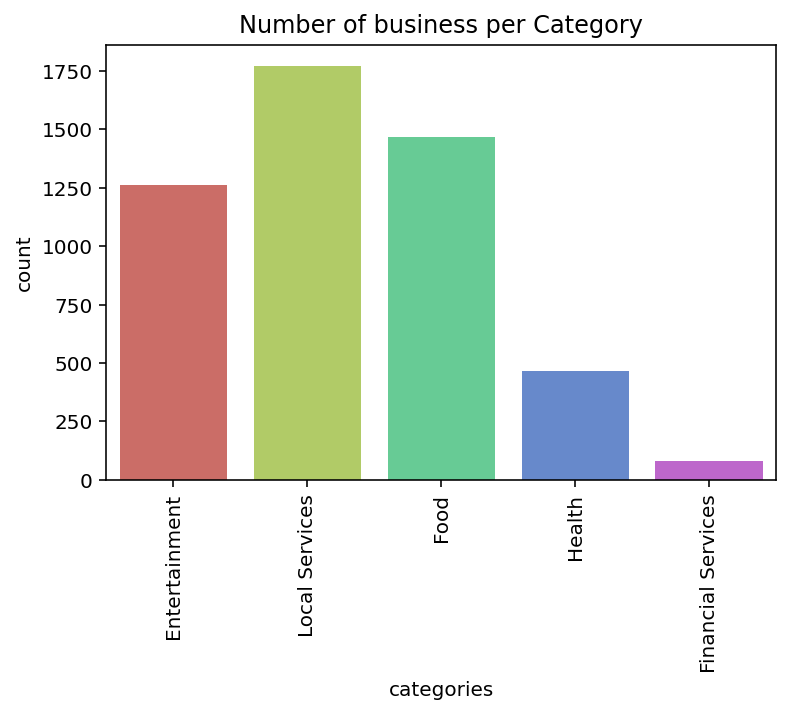

In [14]:
chart = sns.countplot(df['categories'], palette='hls')
plt.title('Number of business per Category')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center', rotation=90);

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5054 entries, 0 to 5106
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5054 non-null   int64  
 1   business_id     5054 non-null   object 
 2   name            5054 non-null   object 
 3   address         4810 non-null   object 
 4   city            5054 non-null   object 
 5   state           5054 non-null   object 
 6   postal_code     5048 non-null   object 
 7   latitude        5054 non-null   float64
 8   longitude       5054 non-null   float64
 9   stars           5054 non-null   float64
 10  review_count    5054 non-null   int64  
 11  is_open         5054 non-null   int64  
 12  attributes      4387 non-null   object 
 13  categories      5054 non-null   object 
 14  hours           4306 non-null   object 
 15  url             5054 non-null   object 
 16  webpage_text    5054 non-null   object 
 17  is_eng          5054 non-null   b

In [16]:
folder_path = os.path.join(FOLDER_PATH, 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for category detection of businesses based on their website contents!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'category', 'detection', 'of', 'businesses', 'based', 'on', 'their', 'website', 'contents', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 4696, 10788, 1997, 5661, 2241, 2006, 2037, 4037, 8417, 999]


In [17]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer

def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False

In [18]:
class categoryDetection:    
    def __init__(self, train, test, tokenizer: FullTokenizer, text_colname=None, label_colname=None, max_seq_len=128):
        """  
        """
        self.text_colname = 'webpage_corpus' if text_colname is None else text_colname
        if not self.text_colname in train.columns or not self.text_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the corpus.')
            return
        
        self.label_colname = 'categories' if label_colname is None else label_colname
        if not self.label_colname in train.columns or not self.label_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the labels.')
            return
        
        self.classes = train[self.label_colname].unique().tolist()
        self.classes.sort()
        
        train = train.dropna(subset=[self.text_colname])
        test = test.dropna(subset=[self.text_colname])
        
        self.max_seq_len = 0
        self.tokenizer = tokenizer
        (self.train_x, self.train_y), (self.test_x, self.test_y) = map(self._tokanize, [train, test])
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._cut_with_padding, [self.train_x, self.test_x])
    
    def build_model(self, bert_config_file, bert_ckpt_file, dropout=0.5, adapter_size=64):
        """
        """
        bert = self._load_bert(bert_config_file, bert_ckpt_file, adapter_size)
        input_ = keras.layers.Input(shape=(self.max_seq_len, ), dtype='int64', name="input_ids")
        x = bert(input_)
        #get the first embedding from the output of BERT
        x = keras.layers.Lambda(lambda seq: seq[:,0,:])(x)
        
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(800, activation='relu')(x)
        #x = keras.layers.Dense(300, activation='relu')(x)
        output_ = keras.layers.Dense(units=len(self.classes), activation='softmax')(x)
        
        model = keras.Model(inputs=input_, outputs=output_)
        model.build(input_shape=(None, self.max_seq_len))
        
        load_stock_weights(bert, bert_ckpt_file)
        
        if adapter_size is not None:
            freeze_bert_layers(bert)
 
        return model
    
    def _load_bert(self, bert_config_file, bert_ckpt_file, adapter_size):
        try:
            with tf.io.gfile.GFile(bert_config_file, 'r') as gf:
                bert_config = StockBertConfig.from_json_string(gf.read())
                bert_params = map_stock_config_to_params(bert_config)
                bert_params.adapter_size = adapter_size
                bert = BertModelLayer.from_params(bert_params, name='bert')
                return bert
        except Exception as e:
            print(e)
    
    def _tokanize(self, df):
        """
        """
        X, y = [], []
        all_tokens = []
        for _, entry in tqdm(df.iterrows()):
            corpus, label = entry[self.text_colname], entry[self.label_colname]
            tokens = self.tokenizer.tokenize(corpus)
            tokens = self._clean_tokens(tokens)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            L = 0
            for x in tokens:
                if '#' in x: continue
                L += 1
            L -= 2
            if L <= 50:
            #    print(tokens)
                continue
            all_tokens.append(tokens)
            ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(ids))
            X.append(ids)
            y.append(self.classes.index(label))
            
        print('{}%'.format(len(X) / len(df) * 100.0))
        all_tokens = sorted(all_tokens, key=lambda x: len(x))
        #print(all_tokens[:20])
        
        return np.asarray(X), np.asarray(y)
    
    
    def _clean_tokens(self, tokens):
        # STOPS = set(stopwords.words('english'))
        clean_tokens = []
        for token in tokens:
            if any(map(str.isdigit, token)): 
                continue
            clean_tokens.append(token)
        return clean_tokens
    def _cut_with_padding(self, ids):
        """
        """
        X = []
        CLS_id = self.tokenizer.convert_tokens_to_ids(['[CLS]'])
        SEP_id = self.tokenizer.convert_tokens_to_ids(['[SEP]'])
        for token_id in ids:
            # ignore tokens '[CLS]' and '[SEP]' for now
            arr = token_id[1:-1]
            sz = min(len(arr), self.max_seq_len - 2)
            arr = CLS_id + arr[:sz] + SEP_id
            # pad the remaining cells with zero
            arr = arr + [0] * (self.max_seq_len - len(arr))
            X.append(np.asarray(arr))
        return np.asarray(X)

In [19]:
def compile_model(cat:categoryDetection, model, validation_split=0.05, batch_size=16, n_epochs=30, shuffle=True):
    #log_dir = "/home/wliang_google_com/Documents/workspace/notebook/.log/website_rating/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])
    print(model.summary())
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(
        x=cat.train_x,
        y=cat.train_y,
        validation_split=validation_split,
        batch_size=batch_size,
        shuffle=shuffle,
        verbose=1,
        epochs=n_epochs,
        #callbacks=[tensorboard_callback],
    )

In [20]:
df['webpage_corpus'][:10]

0    Shooting Ranges Gun Rental Charlotte NC The Ra...
1                                                  NaN
2    Home Renovations and Repairs Phoenix AZ Home U...
3                                                  NaN
4    Website Disabled Sorry the site you requested ...
5    1 Choice for Fitness MMA in Etobicoke GTA 4165...
6                                                  NaN
7    Chocolate Shoppe Ice Cream Skip to main conten...
8    Home Convertabath Menu Home Remodeling TruSton...
9    Not Found Not Found HTTP Error 404 The request...
Name: webpage_corpus, dtype: object

In [21]:
split_sz = int(len(df) * 0.8)
train = df[:split_sz]
test = df[split_sz:]

In [22]:
cat = categoryDetection(train, test, tokenizer, max_seq_len=256)

2527it [00:31, 79.54it/s] 
4it [00:00, 38.38it/s]

89.39453897902652%


632it [00:08, 76.30it/s] 


87.9746835443038%


In [23]:
model = cat.build_model(bert_config_file, bert_ckpt_file)

loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/output/

loader: No value for:[bert/encoder/layer_8/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_8/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_8/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_8/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/output/

In [24]:
compile_model(cat, model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 256, 768)          111269376 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 800)               615200    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 4005      
Total params: 111,888,581
Trainable params: 3,035,333
Non-trainable params: 108,853,248
_______________________________________

In [25]:
model.evaluate(cat.test_x, cat.test_y);

18/18 [==============================] - 4s 209ms/step - loss: 1.1186 - acc: 0.7788


In [46]:
def testing(text, LEN=256):
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    ids = ids + [0 for _ in range(LEN  - len(ids))]
    ids = ids[:LEN]
    y_pred = model.predict([ids])
    print(cat.classes[np.argmax(y_pred)])
    print(y_pred)

In [49]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text)

Food
[[1.4111267e-02 1.0460065e-03 9.8196614e-01 2.8112798e-03 6.5169086e-05]]


In [54]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text)

Local Services
[[4.6295552e-03 7.9173871e-05 6.0874696e-05 2.8093143e-03 9.9242109e-01]]
